In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-09-02 10:52:13.002658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 10:52:14.291983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%%bash

#Download model weights
for fold in f0 f1 f2 f3; do
  mkdir -p "saved_models/$fold/"
  local_model="saved_models/$fold/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$fold model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$fold/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
if [ -f gencode41_basic_nort.gtf ]; then
  echo "Annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
fi
if [ -f gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
fi
if [ -f polyadb_human_v3.csv.gz ]; then
  echo "PolyA sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
if [ -f hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
fi

bash: /home/drk/anaconda3/envs/tf12/lib/libtinfo.so.6: no version information available (required by bash)


f0 model already exists.
f1 model already exists.
f2 model already exists.
f3 model already exists.
Annotation already exists.
Splice sites already exist.
PolyA sites already exist.
Human genome FASTA already exists.


In [3]:
pyfaidx.Faidx('hg38.fa')

Faidx("hg38.fa")

In [4]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 4       #To use only one model fold, change to 'n_folds = 1'
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, '0')
    
    models.append(seqnn_model)


In [5]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load splice site annotation

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [6]:
#Load GTF (optional; needed to compute exon coverage attributions for example gene)

transcriptome = bgene.Transcriptome('gencode41_basic_nort.gtf')

search_gene = 'ENSG00000187164'
center_pos = 116952944
chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)


In [7]:
#Print index of GTEx blood and muscle tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("blood tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['local_index'].tolist()))
print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))


blood tracks = [9, 10, 11]
muscle tracks = [47, 48, 49]


-- Counts --
 - sum_wt = 127138.67
 - sum_mut = 126502.67
 - max_y_wt = 809.7634
 - max_y_mut = 810.978
 -- (max_y = 810.978)


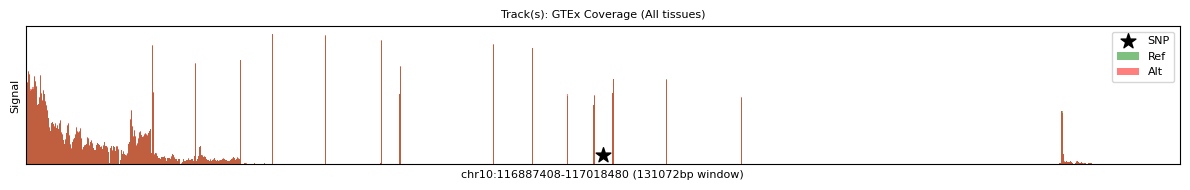

 - sum_wt = 43400.94
 - sum_mut = 53960.75
 - max_y_wt = 339.3114
 - max_y_mut = 423.4269
 -- (max_y = 423.4269)


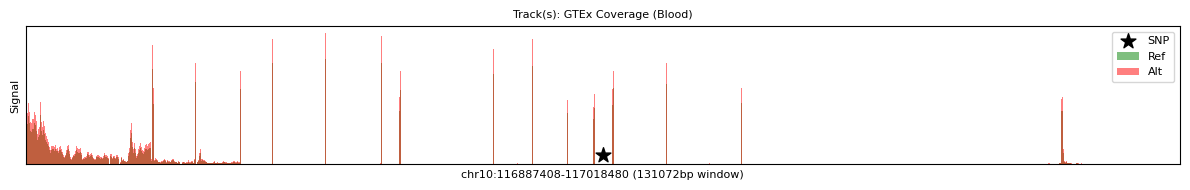

 - sum_wt = 32183.52
 - sum_mut = 33052.125
 - max_y_wt = 296.1789
 - max_y_mut = 302.3407
 -- (max_y = 302.3407)


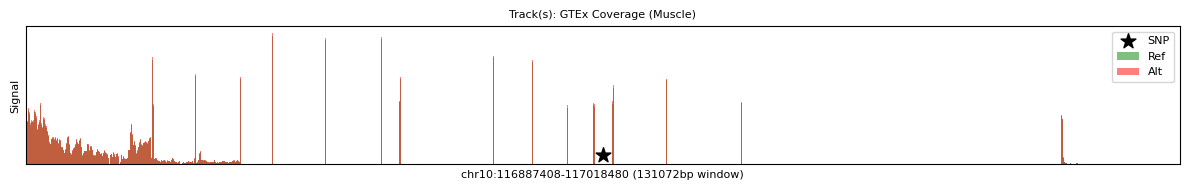

CPU times: user 25min 15s, sys: 39min 20s, total: 1h 4min 36s
Wall time: 6min 5s


In [8]:
%%time
#Predict for chr10_116952944_T_C
# (~6 minutes on CPU)

save_figs = False
save_suffix = '_chr10_116952944_T_C'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 131072
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [0.01]*3
track_transforms = [3./4.]*3
soft_clips = [384.]*3

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=1 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
)

In [9]:
%%time
#Get contribution scores (gradient) for blood GTEX tracks
# (~8 minutes on CPU)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0],  
)
# track_index=target_index[[9, 10, 11]].tolist(),
# fold_index=[0, 1, 2, 3],

2023-09-02 11:03:08.196466: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2684354560 exceeds 10% of free system memory.


1/1 [==============================] - 210s 210s/step


2023-09-02 11:03:42.922857: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2684354560 exceeds 10% of free system memory.


1/1 [==============================] - 35s 35s/step


2023-09-02 11:07:27.576249: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2684354560 exceeds 10% of free system memory.


1/1 [==============================] - 211s 211s/step


2023-09-02 11:08:04.317696: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2684354560 exceeds 10% of free system memory.


1/1 [==============================] - 37s 37s/step
CPU times: user 19min 13s, sys: 14min 31s, total: 33min 45s
Wall time: 8min 40s


--- WT ---


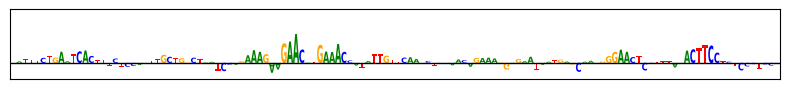

--- Mut ---


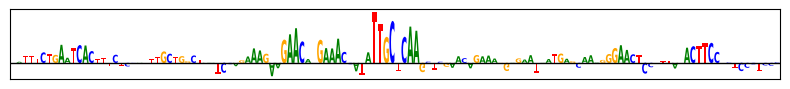

CPU times: user 866 ms, sys: 33.6 ms, total: 899 ms
Wall time: 1.11 s


In [10]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [11]:
%%time
#Get contribution scores (ISM) for blood GTEX tracks
# (~30 minutes on CPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0


KeyboardInterrupt: 

In [12]:
%%time
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


NameError: name 'pred_ism_wt' is not defined

In [13]:
%%time
#Get contribution scores (ISM shuffle) for blood GTEX tracks
# (~30 minutes on CPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    window_size=7,
    n_samples=24,
    dinuc_shuffle=True,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0


KeyboardInterrupt: 

In [14]:
%%time
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


NameError: name 'pred_ism_wt' is not defined

In [15]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()


FileNotFoundError: [Errno 2] No such file or directory: 'gtex_ref_chr10_116952944_T_C.txt'

In [ ]:
%%time
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C_meas_32_subjects'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 131072
bin_size = 32
pad = 16

anno_df = None #splice_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(32).tolist(),
]

track_names = [
    'GTEx Blood (32 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(
    gtex_targets_wt[None, None, ...],
    gtex_targets_mut[None, None, ...],
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=4 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
)